# Predicting cryptocurrencies: Seq-to-Seq Regression
The problem can be approached from two different perspectives:
* Classification (e.g. buy, hold, sell)
* Regression (future price)

In this notebook we'll approach the problem from a **regression** perspective, trying to predict the price of a cryptocurrency in the next 10 minutes from the observation of 4 cryptocurrencies prices in the previous 60 minutes (**sequence-to-sequence**).

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Lorenzo-Giardi/tf-keras/blob/master/6_RNN/6_seqtoseq_reg_cryptos_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Imports and global parameters

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from sklearn import preprocessing
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization, Flatten, Conv1D, TimeDistributed, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [2]:
from rnn_utils import generate_time_series, plot_series, plot_multiple_forecasts, last_time_step_mse, plot_learning_curves

In [3]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
print(f'Current date and time: {now}')

SEQ_LEN = 30 # last minutes to use as feature
FUTURE_PERIOD_PREDICT = 1 # period over which to make the prediction
STOCK_TO_PREDICT = "BA"
EPOCHS = 20
BATCH_SIZE = 64
NAME = f'{STOCK_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED_{now}'

Current date and time: 2020-03-26_14:03:43


## Import Data

In [4]:
#col_names = ['time', 'low', 'high', 'open', 'close', 'volume']
#df = pd.read_csv("crypto_data/LTC-USD.csv", names = col_names)
df = pd.read_csv(f"stocks_data/{STOCK_TO_PREDICT}.csv")
df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")
print(df.head())

        Date      Open      High       Low     Close  Adj Close  Volume
0 1962-01-02  0.837449  0.837449  0.823045  0.823045   0.145748  352200
1 1962-01-03  0.835391  0.851852  0.835391  0.839506   0.148663  710400
2 1962-01-04  0.839506  0.853909  0.831276  0.831276   0.147205  911000
3 1962-01-05  0.831276  0.835391  0.792181  0.814815   0.144290  880400
4 1962-01-08  0.814815  0.829218  0.804527  0.816872   0.144654  473600


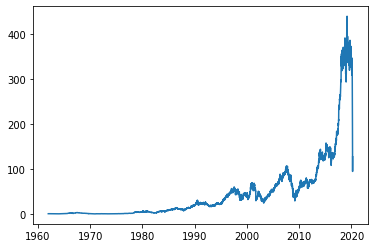

In [5]:
plt.plot(df['Date'], df['Close'])
plt.show()

In [6]:
os.listdir('stocks_data')

['PEP.csv',
 'KO.csv',
 'GE.csv',
 'DIS.csv',
 'MSFT.csv',
 'AAPL.csv',
 'INTC.csv',
 'BAC.csv',
 'BA.csv']

In [7]:
main_df = pd.DataFrame()

stocks = ['PEP', 'KO', 'GE', 'DIS', 'MSFT', 'AAPL', 'INTC', 'BAC', 'BA']
for stock in stocks:
    # read CSV from path
    df_path = f'stocks_data/{stock}.csv'
    df = pd.read_csv(df_path)
    df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    
    # rename columns
    df.rename(columns = {'Close': f'{stock}_close', 'Volume': f'{stock}_volume'}, inplace = True)
    # set time as index
    df.set_index('Date', inplace = True)
    # select only close price and volume columns
    df = df[[f'{stock}_close', f'{stock}_volume']]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)

print(main_df.head())

            PEP_close  PEP_volume  KO_close  KO_volume  GE_close  GE_volume  \
Date                                                                          
1972-06-01   1.601852      318600  1.377604     748800  1.389724    1642300   
1972-06-02   1.597222      140400  1.372396     393600  1.382212    2985200   
1972-06-05   1.574074      469800  1.369792     662400  1.382212    1088200   
1972-06-06   1.560185      140400  1.358073     768000  1.387220    2525900   
1972-06-07   1.550926      178200  1.351563    1420800  1.357171    1802100   

            DIS_close  DIS_volume  MSFT_close  MSFT_volume  AAPL_close  \
Date                                                                     
1972-06-01   1.893361     1138500         NaN          NaN         NaN   
1972-06-02   1.901068     2082500         NaN          NaN         NaN   
1972-06-05   1.897214      681100         NaN          NaN         NaN   
1972-06-06   1.893361      739500         NaN          NaN         NaN   
19

In [8]:
# Define a new column with future price
main_df['target'] = main_df[f'{STOCK_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
print(main_df[[f'{STOCK_TO_PREDICT}_close', 'target']].head())

            BA_close    target
Date                          
1972-06-01  0.736625  0.728395
1972-06-02  0.728395  0.724280
1972-06-05  0.724280  0.703704
1972-06-06  0.703704  0.699588
1972-06-07  0.699588  0.703704


## Train-test split, normalization, sequence creation and data balancing

Notice that since sequences are very close together and are highly correlated, it would be a bad idea to take a random sample to use as a validation/test set, as it would be extremely similar to instances in the training set. Instead, we have to take a whole period (possibly the most recent one) and use it for testing.

In this case we'll take the last 5-10% of the data.

In [9]:
# ensure that time is sorted
times = sorted(main_df.index.values)
threshold = times[-int(0.1*len(times))]
print(f'Time threshold for train-validation split: {threshold}')

Time threshold for train-validation split: 2015-06-11T00:00:00.000000000


In [10]:
# tain-validation split
validation_main_df = main_df[(main_df.index >= threshold)]
train_main_df = main_df[(main_df.index < threshold)]

Now define a preprocessing function that will be applied to both, the training and validation sets.
* Transform absolute prices into percentage changes
* Normalize data to be in (0,1)
* Drop NAs
* Create sequences that will be used as features (X)

In [11]:
# define a preprocessing function
def preprocess_df(df, print_df = False):
    
    pd.options.mode.chained_assignment = None
    # transform data to percentage variation and normalize
    for col in df.columns:
        #if col != 'target':
        df[col] = df[col].pct_change()
        df.dropna(inplace = True)
        df[col] = preprocessing.scale(df[col].values)
            
    df.dropna(inplace = True)
    
    if print_df: 
        print(df[[f'{STOCK_TO_PREDICT}_close', 'target']].head())
        plt.plot(df[f'{STOCK_TO_PREDICT}_close'])
        plt.show()
    
    # create sequences of lenght SEQ_LEN to be used as features (X)
    # sequential_data is a list [sequences(X), targets(y)]
    sequential_data = []
    prev_days = deque(maxlen = SEQ_LEN)
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
            
    random.shuffle(sequential_data)
    if print_df: print('\nsequential_data shape: ', np.shape(sequential_data))
        
    # split into X and y
    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
    if print_df: print('\nDimensions: [n of sequences, sequences lenght, features]')
    if print_df: print('X_data shape: ', np.shape(X))
    if print_df: print('y_data shape: ', np.shape(y))
    
    return np.array(X), np.array(y)

            BA_close    target
Date                          
1986-04-09  0.565510  0.090264
1986-04-10  0.090006 -0.026980
1986-04-11 -0.027233 -0.026980
1986-04-14 -0.027233  0.323974
1986-04-15  0.323708  1.251373


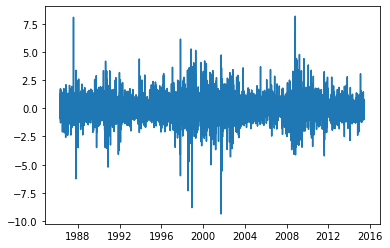


sequential_data shape:  (7326, 2)

Dimensions: [n of sequences, sequences lenght, features]
X_data shape:  (7326, 30, 18)
y_data shape:  (7326,)


In [12]:
train_x, train_y = preprocess_df(train_main_df, print_df = True)
valid_x, valid_y = preprocess_df(validation_main_df)

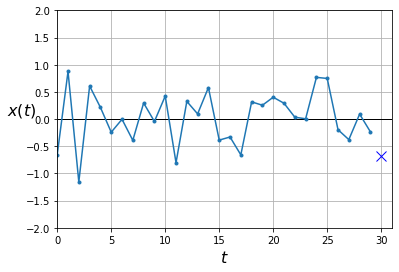

In [13]:
plot_series(train_x[0, :, 0], train_y[0], n_steps = SEQ_LEN)
plt.show()

## Linear Baseline

In [14]:
model_bsl = Sequential([
        Flatten(input_shape = (train_x.shape[1:])),
        Dense(1)])

model_bsl.compile(loss = 'mse', optimizer = 'nadam')

history_bsl = model_bsl.fit(train_x, train_y,
                   batch_size = BATCH_SIZE,
                   epochs = 10,
                   validation_data = (valid_x, valid_y))

Train on 7326 samples, validate on 1156 samples
Epoch 1/10
7326/7326 [==============================] - 1s 76us/sample - loss: 2.2114 - val_loss: 1.6350
Epoch 2/10
7326/7326 [==============================] - 0s 23us/sample - loss: 1.4703 - val_loss: 1.3282
Epoch 3/10
7326/7326 [==============================] - 0s 25us/sample - loss: 1.2140 - val_loss: 1.2038
Epoch 4/10
7326/7326 [==============================] - 0s 30us/sample - loss: 1.0958 - val_loss: 1.1497
Epoch 5/10
7326/7326 [==============================] - 0s 31us/sample - loss: 1.0367 - val_loss: 1.1399
Epoch 6/10
7326/7326 [==============================] - 0s 25us/sample - loss: 1.0039 - val_loss: 1.1222
Epoch 7/10
7326/7326 [==============================] - 0s 23us/sample - loss: 0.9883 - val_loss: 1.1158
Epoch 8/10
7326/7326 [==============================] - 0s 35us/sample - loss: 0.9764 - val_loss: 1.1188
Epoch 9/10
7326/7326 [==============================] - 0s 25us/sample - loss: 0.9696 - val_loss: 1.1337
Epoch 1

In [15]:
y_pred = model_bsl.predict(valid_x)
val_y = valid_y[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {val_y.shape}')

Predictions shape: (1156, 1)
valid_x shape: (1156, 30, 18)
valid_y shape: (1156, 1)


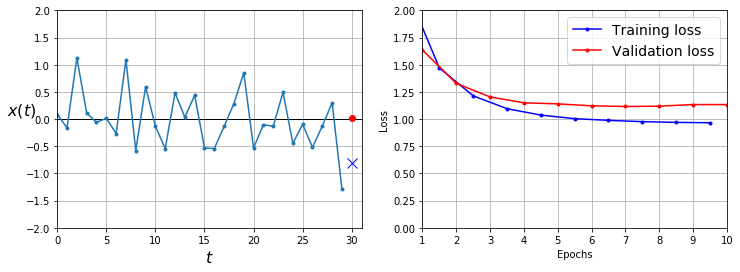

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

seq = randint(450, 500)

plt.sca(axes[0])
plot_series(valid_x[seq, :, 0], val_y[seq, 0], y_pred[seq, 0], n_steps = SEQ_LEN)

plt.sca(axes[1])
plot_learning_curves(history_bsl.history["loss"], history_bsl.history["val_loss"], axis = [1, 10, 0, 2])

plt.show()

## Recurrent Network


In [17]:
model = Sequential([
    
    GRU(32, activation = 'tanh', return_sequences = True, input_shape = train_x.shape[1:]),
    Dropout(0.2),
    BatchNormalization(),
    
    GRU(32, activation = 'tanh', return_sequences = False),
    Dropout(0.2),
    BatchNormalization(),
    
    Dense(32, activation = 'tanh'),
    Dropout(0.2),
    
    Dense(1),
])

opt = tf.keras.optimizers.Adam(lr=0.001, decay = 1e-6)

model.compile(loss = 'mse',
             optimizer = 'nadam'
             )

model.summary()

tensorboard = TensorBoard(log_dir = f'logs/{NAME}')
filepath = "RNN_Final-{epoch:02d}-{val_loss:.3f}.hdf5"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint(f"models/{NAME}/{filepath}", monitor='val_loss', verbose=1, save_best_only=True, mode='auto') # saves only the best ones
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

# create folder for checkpoints (or it will throw an error if not found!)
try:
    os.makedirs(f"models/{NAME}")
except:
    print("Directory already exists")  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 32)            4992      
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [18]:
history = model.fit(train_x, train_y,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (valid_x, valid_y),
                   callbacks = [tensorboard, checkpoint, earlystop])

Train on 7326 samples, validate on 1156 samples
Epoch 1/20
7232/7326 [============================>.] - ETA: 0s - loss: 1.3189
Epoch 00001: val_loss improved from inf to 1.01463, saving model to models/BA-30-SEQ-1-PRED_2020-03-26_14:03:43/RNN_Final-01-1.015.hdf5
7326/7326 [==============================] - 8s 1ms/sample - loss: 1.3167 - val_loss: 1.0146
Epoch 2/20
7232/7326 [============================>.] - ETA: 0s - loss: 1.1477
Epoch 00002: val_loss improved from 1.01463 to 1.01326, saving model to models/BA-30-SEQ-1-PRED_2020-03-26_14:03:43/RNN_Final-02-1.013.hdf5
7326/7326 [==============================] - 4s 567us/sample - loss: 1.1464 - val_loss: 1.0133
Epoch 3/20
7232/7326 [============================>.] - ETA: 0s - loss: 1.0989
Epoch 00003: val_loss did not improve from 1.01326
7326/7326 [==============================] - 4s 522us/sample - loss: 1.0993 - val_loss: 1.0212
Epoch 4/20
7296/7326 [============================>.] - ETA: 0s - loss: 1.0750
Epoch 00004: val_loss did 

In [19]:
y_pred = model.predict(valid_x)
val_y = valid_y[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {val_y.shape}')

Predictions shape: (1156, 1)
valid_x shape: (1156, 30, 18)
valid_y shape: (1156, 1)


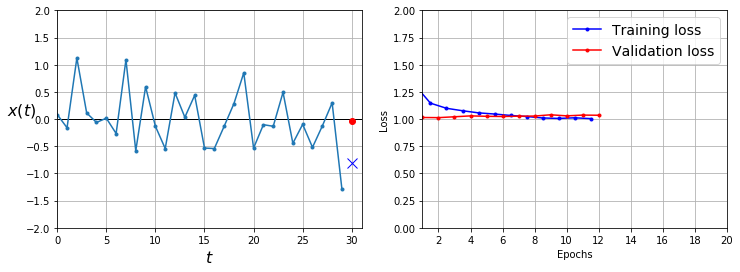

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_series(valid_x[seq, :, 0], val_y[seq, 0], y_pred[seq, 0], n_steps = SEQ_LEN)

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"], axis = [1, EPOCHS, 0, 2])

plt.show()

## with Conv1D

In [21]:
NAME = f'{STOCK_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED_{now}'

model = Sequential([
    
    Conv1D(filters = 64, kernel_size = 4, padding = 'valid', input_shape = train_x.shape[1:]),
    BatchNormalization(),
    
    GRU(20, activation = 'tanh', return_sequences = True ),
    Dropout(0.2),
    BatchNormalization(),
    
    GRU(20, activation = 'tanh', return_sequences = False),
    Dropout(0.2),
    BatchNormalization(),
    
    Dense(32, activation = 'tanh'),
    Dropout(0.2),
    
    Dense(1),
])

opt = tf.keras.optimizers.Adam(lr=0.001, decay = 1e-6)

model.compile(loss = 'mse',
             optimizer = 'nadam'
             )

model.summary()

tensorboard = TensorBoard(log_dir = f'logs/{NAME}')
filepath = "RNN_Final-{epoch:02d}-{val_loss:.3f}.hdf5"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint(f"models/{NAME}/{filepath}", monitor='val_loss', verbose=1, save_best_only=True, mode='auto') # saves only the best ones
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

# create folder for checkpoints (or it will throw an error if not found!)
try:
    os.makedirs(f"models/{NAME}")
except:
    print("Directory already exists")  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 27, 64)            4672      
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 64)            256       
_________________________________________________________________
gru_2 (GRU)                  (None, 27, 20)            5160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 20)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 20)            80        
_________________________________________________________________
gru_3 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)               

In [22]:
history = model.fit(train_x, train_y,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (valid_x, valid_y),
                   callbacks = [tensorboard, checkpoint, earlystop])

Train on 7326 samples, validate on 1156 samples
Epoch 1/20
7296/7326 [============================>.] - ETA: 0s - loss: 1.2221
Epoch 00001: val_loss improved from inf to 1.02532, saving model to models/BA-30-SEQ-1-PRED_2020-03-26_14:03:43/RNN_Final-01-1.025.hdf5
7326/7326 [==============================] - 9s 1ms/sample - loss: 1.2222 - val_loss: 1.0253
Epoch 2/20
7296/7326 [============================>.] - ETA: 0s - loss: 1.1015
Epoch 00002: val_loss did not improve from 1.02532
7326/7326 [==============================] - 3s 470us/sample - loss: 1.1000 - val_loss: 1.0404
Epoch 3/20
7296/7326 [============================>.] - ETA: 0s - loss: 1.0692
Epoch 00003: val_loss did not improve from 1.02532
7326/7326 [==============================] - 4s 519us/sample - loss: 1.0683 - val_loss: 1.0345
Epoch 4/20
7296/7326 [============================>.] - ETA: 0s - loss: 1.0549
Epoch 00004: val_loss did not improve from 1.02532
7326/7326 [==============================] - 3s 467us/sample - l

In [23]:
y_pred = model.predict(valid_x)
val_y = valid_y[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {val_y.shape}')

Predictions shape: (1156, 1)
valid_x shape: (1156, 30, 18)
valid_y shape: (1156, 1)


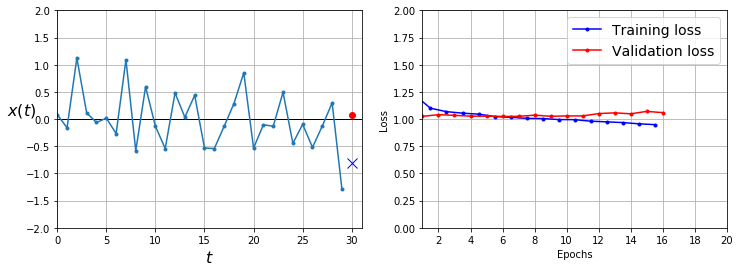

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_series(valid_x[seq, :, 0], val_y[seq, 0], y_pred[seq, 0], n_steps = SEQ_LEN)

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"], axis = [1, EPOCHS, 0, 2])

plt.show()